1. Import necessary packages, and read in data
2. Preprocessing data and apriori feature selection
3. Random Forest: model training, tuning, and evaluation
4. Testing it out!

# Import necessary packages, and read in data

In [41]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [42]:
%pwd


'C:\\Users\\Lokesh Balaji\\Desktop\\NEU Study\\INFO6105'

In [43]:
'''The line below is not code, please make it into code by putting in full path'''
path = 'C:\\Users\\Lokesh Balaji\\Desktop\\NEU Study\\INFO6105'

In [44]:
#Read the data
df = pd.read_csv(f'{path}/Titanic_full.csv')
print(df.shape)
df.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# 2. Preprocessing data and apriori feature selection

In the broadest sense of the term, preprocessing can also include feature selection. Here, we will use our
rationale to feature select. What do the column names mean, does it make sense to what we are trying to do, and should we keep it or drop it?

There are different ways to think about it. For now, let's drop Name, Cabin and Ticket columns.

Let's see if this makes a difference.

In [45]:
'''Keep aside test data first'''

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


df_trn_val,df_tst = mydf_splitter(df,1150)

print(df_trn_val.shape,df_tst.shape)

(1150, 12) (159, 12)


In [46]:
 #Dropping the columns
    df_trn_val1 = df_trn_val.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_trn_val1.shape)
df_trn_val1.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


<AxesSubplot:xlabel='Feature', ylabel='Percent missing'>

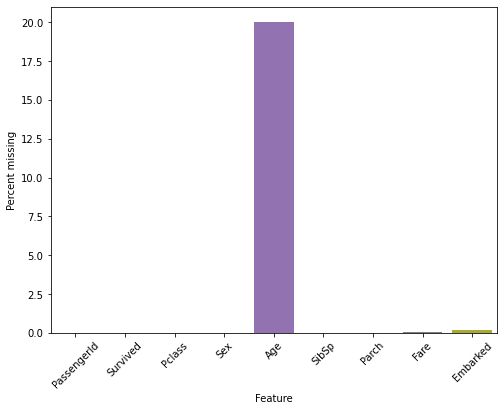

In [47]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = df_trn_val1.isnull().sum()/len(df_trn_val1)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [48]:
#Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [49]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [50]:
df_trn_val2 = str_to_cat(df_trn_val1)
print(df_trn_val2.shape)
df_trn_val2.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


In [51]:
df_trn_val3,my_table = mydf_preprocessor(df_trn_val2,null_table = None)
print(df_trn_val3.shape)
df_trn_val3.head(3)

(1150, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
0,1,0,3,2,22.0,1,0,7.2500,3,False,False
1,2,1,1,1,38.0,1,0,71.2833,1,False,False
2,3,1,3,1,26.0,0,0,7.9250,3,False,False


In [52]:
my_table

{'Age': 28.0, 'Fare': 14.4542}

In [53]:
x = df_trn_val3.drop('Survived', axis=1)
y = df_trn_val3['Survived']

In [54]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, random_state=1)
print(x_trn.shape,x_val.shape,y_trn.shape,y_val.shape)

(862, 10) (288, 10) (862,) (288,)


# Random Forest: model training, tuning, and evaluation

In [55]:
#RandomforestClassifier(n_estimators = 10)

mod_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)
mod_1.fit(x_trn,y_trn)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [56]:
#Calculating Accuracy score
y_prd = mod_1.predict(x_val)
accuracy_score(y_val,y_prd)

0.75

In [57]:
mod_4 = RandomForestClassifier(n_jobs = -1, n_estimators= 50,
                                 bootstrap = True)
mod_4.fit(x_trn,y_trn)
y_prd4 = mod_4.predict(x_val)
accuracy_score(y_val,y_prd4)

0.7430555555555556

In [58]:
mod_5 = RandomForestClassifier(n_jobs = -1, n_estimators= 100,
                                 bootstrap = True)
mod_5.fit(x_trn,y_trn)
y_prd5 = mod_5.predict(x_val)
accuracy_score(y_val,y_prd5)

0.7430555555555556

In [59]:
mod_2 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,
                                 bootstrap = True)
mod_2.fit(x_trn,y_trn)
y_prd2 = mod_2.predict(x_val)
accuracy_score(y_val,y_prd2)

0.7465277777777778

In [60]:
mod_3 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)
mod_3.fit(x_trn,y_trn)
y_prd3 = mod_3.predict(x_val)
accuracy_score(y_val,y_prd3)

0.7430555555555556

In [61]:
mod_6 = RandomForestClassifier(n_jobs = -1, n_estimators= 150,
                                 bootstrap = True)
mod_6.fit(x_trn,y_trn)
y_prd6 = mod_6.predict(x_val)
accuracy_score(y_val,y_prd6)

0.7534722222222222

In [62]:
mod_7 = RandomForestClassifier(n_jobs = -1, n_estimators= 200,
                                 bootstrap = True)
mod_7.fit(x_trn,y_trn)
y_prd7 = mod_7.predict(x_val)
accuracy_score(y_val,y_prd7)

0.7569444444444444

In [63]:
mod_8 = RandomForestClassifier(n_jobs = -1, n_estimators= 250,
                                 bootstrap = True)
mod_8.fit(x_trn,y_trn)
y_prd8 = mod_8.predict(x_val)
accuracy_score(y_val,y_prd8)

0.7361111111111112

In [64]:
mod_9 = RandomForestClassifier(n_jobs = -1, n_estimators= 350,
                                 bootstrap = True)
mod_9.fit(x_trn,y_trn)
y_prd9 = mod_9.predict(x_val)
accuracy_score(y_val,y_prd9)

0.7395833333333334

In [65]:
#Gridsearch

from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(random_state=42)

In [66]:
#Hyperparameters

param_grid = {
               'n_estimators':[10,50,100,150,200,250,300,350,400,500] ,
               'n_jobs' : [-1],
               'bootstrap': [True]
}


In [67]:
#Validation dataset accuracy score with grid search
grid_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid_rfc.fit(x_trn, y_trn)
Y_pred = grid_rfc.predict(x_val)
accuracy_grid_rfc = accuracy_score(y_val,Y_pred)
print(accuracy_grid_rfc)

0.7395833333333334


In [68]:
#Getting the results in Dataframe
grid_sear_pd=pd.DataFrame(grid_rfc.cv_results_)
grid_sear_pd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.648172,1.238013,0.010770,0.006626,True,10,-1,"{'bootstrap': True, 'n_estimators': 10, 'n_job...",0.710983,0.774566,0.726744,0.808140,0.767442,0.757575,0.034826,9
1,0.085771,0.006938,0.016157,0.002779,True,50,-1,"{'bootstrap': True, 'n_estimators': 50, 'n_job...",0.728324,0.751445,0.755814,0.767442,0.796512,0.759907,0.022282,4
2,0.143217,0.005448,0.021941,0.001784,True,100,-1,"{'bootstrap': True, 'n_estimators': 100, 'n_jo...",0.739884,0.757225,0.732558,0.767442,0.796512,0.758724,0.022564,8
3,0.212434,0.002535,0.030318,0.001017,True,150,-1,"{'bootstrap': True, 'n_estimators': 150, 'n_jo...",0.739884,0.745665,0.744186,0.773256,0.790698,0.758738,0.019851,5
4,0.255160,0.004439,0.035903,0.001092,True,200,-1,"{'bootstrap': True, 'n_estimators': 200, 'n_jo...",0.734104,0.751445,0.738372,0.784884,0.784884,0.758738,0.022100,5
5,0.307560,0.009094,0.050556,0.007618,True,250,-1,"{'bootstrap': True, 'n_estimators': 250, 'n_jo...",0.728324,0.757225,0.738372,0.773256,0.784884,0.756412,0.021021,10
6,0.392262,0.007018,0.053058,0.000976,True,300,-1,"{'bootstrap': True, 'n_estimators': 300, 'n_jo...",0.734104,0.751445,0.750000,0.767442,0.790698,0.758738,0.019150,5
7,0.442605,0.023865,0.061400,0.001895,True,350,-1,"{'bootstrap': True, 'n_estimators': 350, 'n_jo...",0.751445,0.745665,0.750000,0.773256,0.790698,0.762213,0.017160,2
8,0.474751,0.007710,0.067996,0.001184,True,400,-1,"{'bootstrap': True, 'n_estimators': 400, 'n_jo...",0.751445,0.745665,0.750000,0.767442,0.790698,0.761050,0.016558,3
9,0.592156,0.015374,0.083795,0.002508,True,500,-1,"{'bootstrap': True, 'n_estimators': 500, 'n_jo...",0.745665,0.745665,0.755814,0.767442,0.796512,0.762219,0.018933,1


In [69]:
#Best Parameters
grid_rfc.best_params_

{'bootstrap': True, 'n_estimators': 500, 'n_jobs': -1}

In [70]:
grid_sear_pd_1 = grid_sear_pd[['param_n_estimators','split0_test_score']]
print(grid_sear_pd_1)

  param_n_estimators  split0_test_score
0                 10           0.710983
1                 50           0.728324
2                100           0.739884
3                150           0.739884
4                200           0.734104
5                250           0.728324
6                300           0.734104
7                350           0.751445
8                400           0.751445
9                500           0.745665


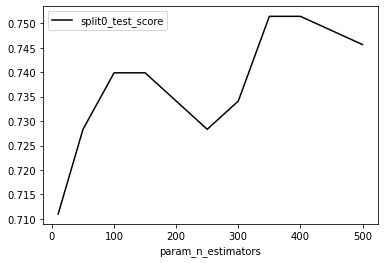

In [71]:
#Line Graph
import matplotlib.pyplot as plt
import pandas as pd
 
ax = plt.gca()
grid_sear_pd_1 .plot(kind='line',x='param_n_estimators',y='split0_test_score', color='black', ax=ax)

plt.show()

Theoretically, increasing the number of decision trees (n_estimators), increases classifier performance and/or generalizability.
The Above graph shows the computational experiment to test the scenario of increasing the number of trees increases performance.In this case it shows their is a variation in performance upto a limit.
But this scenario or relatinship between the estimators and decision trees varies depending on the dataset.In Some cases it
depends on the type of variables used whether they are significant or non significant.If we use large number of noise variables 
the random forests tend to behave differently and the performance of the classifier reduces.
